Elaborado por Israel Cevallos

# <center>DESTILACIÓN BATCH</center>

# Ejercicio 9.1 Wankat

We wish to use a simple batch still (one equilibrium stage) to separate methanol from water. The feed
charge to the still pot is 50 moles of an 80 mol% methanol mixture. We desire an average distillate
concentration of 89.2 mol% methanol. Find the amount of distillate collected, the amount of material
left in the still pot, and the concentration of material in the still pot. Pressure is 1 atm. Methanol-water
equilibrium data at 1 atm are given in Table 2-7 in Problem 2.D1.

<img src="https://i.imgur.com/OKljCVF.png" align="top" width=300 height=300>

## Cargado de datos

Primero se cargan los datos de equilibrio del problema

In [1]:
#Librerías principales
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

datos = pd.read_excel("Ejemplo 9.1 Destilación Batch.xlsx", sheet_name="Data")

#Datos del problema
F = 50 #mol
xF = 0.80
xDavg = 0.892

datos

,x,y
0,0.00,0.000
1,0.02,0.134
2,0.04,0.230
3,0.06,0.304
4,0.08,0.365
5,0.10,0.418
6,0.15,0.517
7,0.20,0.579
8,0.30,0.665
9,0.40,0.729


Se genera el plot de la curva de equilibrio

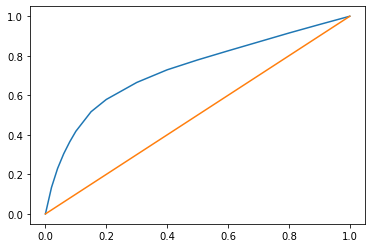

In [2]:
plt.figure()
plt.plot(datos["x"],datos["y"])
plt.plot([0,1],[0,1])

## Método 1. Integrar la función de la curva $1/(y-x)$ vs $x$ con la librería Sympy

Primero se hace un slice de los datos de equilibrio a utilizar

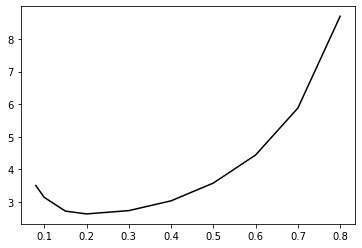

In [3]:
#Se cortan desde x=0.08 hasta x=0.8 (10 puntos)
datosx = list(datos["x"])
eqx = datosx[4:len(datosx)-3]

#Se genera la lista de la nueva función (1/(y-x))
datosy = list(1/(datos["y"]-datos["x"]))
eqy = datosy[4:len(datosy)-3]

#Convirtiendo las listas a arreglos de numpy
X_p = np.array(eqx).reshape(len(eqx),1)
Y_p = np.array(eqy).reshape(len(eqy),1)

#Ploteado de los puntos
plt.figure()
plt.plot(X_p,Y_p,c="k")

Con los datos de la nueva función, se quiere obtener la ecuación de la curva por regresión polinomial. Utilizando la librería sklearn

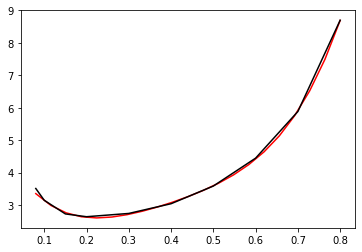

In [4]:
from sklearn import linear_model
########## IMPLEMENTACIÓN DE REGRESIÓN POLINOMIAL ##########
from sklearn.model_selection import train_test_split
#Separo los datos de "train" en entrenamiento y prueba para probar los algoritmos
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_p, Y_p, test_size=0.1)
from sklearn.preprocessing import PolynomialFeatures
#Se define el grado del polinomio (4 en este caso)
poli_reg = PolynomialFeatures(degree = 4)
#Se transforma las características existentes en características de mayor grado
X_train_poli = poli_reg.fit_transform(X_train_p)
X_test_poli = poli_reg.fit_transform(X_test_p)
#Defino el algoritmo a utilizar
pr = linear_model.LinearRegression()
#Entreno el modelo
pr.fit(X_train_poli, y_train_p)

#Los coeficientes e intercepto de la ecuación de grado 4
coeficientes = pr.coef_
intercepto = pr.intercept_

#Generando 20 puntos en x para la ecuación obtenida
x = np.linspace(eqx[0],eqx[-1],21)
x = x.reshape(len(x),1)
a1 = coeficientes[0,1]
a2 = coeficientes[0,2]
a3 = coeficientes[0,3]
a4 = coeficientes[0,4]

b = intercepto[0]

#Generando los puntos de la función
y = b + a1*x + a2*x**2 + a3*x**3 + a4*x**4

#Comprobando la función estimada por regresión polinomial
plt.figure()
plt.plot(x,y,c="r")
plt.plot(X_p,Y_p,c="k")  #Para comparar con los datos originales

Utilizando la librería sympy se va a integrar la función entre los límites $(x_{Wf}$ supuesto y $x_F)$, con ello calcular el flujo de fondo $W$ y, por último, el $x_{Davg}$

In [5]:
#Utilizando z como variable para evitar conflicto con la variable x
from sympy import integrate
from sympy.abc import z

#Ecuación de la función a integrar (obtenida con sklearn)
f = b + a1*z + a2*z**2 + a3*z**3 + a4*z**4

#Suponiendo la composición del fondo
xWf = 0.67
area = integrate(f,(z,xWf,xF))

#Calculando el valor de W
W = F*math.exp(-area) #mol
D = F-W #mol

#Calculando el xD
xDcalc = (F*xF-W*xWf)/(F-W)

#Porcentaje de error del xD respecto al propuesto por el problema
error = abs((xDavg-xDcalc)/xDavg)*100

Se genera el mensaje con los resultados

In [6]:
print("La cantidad de destilado es %.2f moles, la del residuo es %.2f moles y la composición en ésta es %.3f" %(D, W, xWf))
print("El porcentaje de error en la composición de destilado promedio calculada (%.3f) es %.3f%%" %(xDcalc,error))

La cantidad de destilado es 29.35 moles, la del residuo es 20.65 moles y la composición en ésta es 0.670
El porcentaje de error en la composición de destilado promedio calculada (0.891) es 0.062%


## Método 2. Integrar por Simpson

En los datos de que disponemos se supone que la composición en el residuo está entre 0.5 y 0.8, a falta de puntos para la integral (a mayor cantidad más aproximación a la integral) se pueden interpolar, buscar en referencias, o en todo caso utilizar la función que generamos anteriormente por regresión polinómica. Recordar que Simpson (ya sea 1/3 o 3/8) utiliza puntos equidistantes. En este caso se utilizará la función obtenida por regresión y Simpson de 3/8

### Intento 1. $x_{Wf} = 0.5$

In [7]:
#Generando los 4 puntos para la cuadratura
puntosx1 = np.linspace(0.5,0.8,4)
puntosy1 = b + a1*puntosx1 + a2*puntosx1**2 + a3*puntosx1**3 + a4*puntosx1**4
xWf1 = puntosx1[0]

#Calculando la integral por Simpson 3/8
integral1 = ((puntosx1[3]-puntosx1[0])/8)*(puntosy1[0]+3*puntosy1[1]+3*puntosy1[2]+puntosy1[3])
W1 = F*math.exp(-integral1)
D1 = F-W1
xDcalc1 = (F*xF-W1*xWf1)/(F-W1)
error1 = abs((xDavg-xDcalc1)/xDavg)*100
print("RESULTADOS")
print("Composición del fondo: %.3f" %xWf1)
print("Cantidad en el fondo: %.2f moles" %W1)
print("Cantidad en el destilado: %.2f moles" %D1)
print("Composición en el destilado calculada: %.3f" %xDcalc1)
print("Error en la composición en el destilado: %.2f%%" %error1)

RESULTADOS
Composición del fondo: 0.500
Cantidad en el fondo: 9.88 moles
Cantidad en el destilado: 40.12 moles
Composición en el destilado calculada: 0.874
Error en la composición en el destilado: 2.03%


### Intento 2 $x_{Wf} = 0.7$

In [8]:
#Generando los 4 puntos para la cuadratura
puntosx2 = np.linspace(0.7,0.8,4)
puntosy2 = b + a1*puntosx2 + a2*puntosx2**2 + a3*puntosx2**3 + a4*puntosx2**4
xWf2 = puntosx2[0]

#Calculando la integral por Simpson 3/8
integral2 = ((puntosx2[3]-puntosx2[0])/8)*(puntosy2[0]+3*puntosy2[1]+3*puntosy2[2]+puntosy2[3])
W2 = F*math.exp(-integral2)
D2 = F-W2
xDcalc2 = (F*xF-W2*xWf2)/(F-W2)
error2 = abs((xDavg-xDcalc2)/xDavg)*100
print("RESULTADOS")
print("Composición del fondo: %.3f" %xWf2)
print("Cantidad en el fondo: %.2f moles" %W2)
print("Cantidad en el destilado: %.2f moles" %D2)
print("Composición en el destilado calculada: %.3f" %xDcalc2)
print("Error en la composición en el destilado: %.2f%%" %error2)

RESULTADOS
Composición del fondo: 0.700
Cantidad en el fondo: 24.44 moles
Cantidad en el destilado: 25.56 moles
Composición en el destilado calculada: 0.896
Error en la composición en el destilado: 0.41%


### Intento 3 $x_{Wf} = 0.65$

In [9]:
#Generando los 4 puntos para la cuadratura
puntosx3 = np.linspace(0.65,0.8,4)
puntosy3 = b + a1*puntosx3 + a2*puntosx3**2 + a3*puntosx3**3 + a4*puntosx3**4
xWf3 = puntosx3[0]

#Calculando la integral por Simpson 3/8
integral3 = ((puntosx3[3]-puntosx3[0])/8)*(puntosy3[0]+3*puntosy3[1]+3*puntosy3[2]+puntosy3[3])
W3 = F*math.exp(-integral3)
D3 = F-W3
xDcalc3 = (F*xF-W3*xWf3)/(F-W3)
error3 = abs((xDavg-xDcalc3)/xDavg)*100
print("RESULTADOS")
print("Composición del fondo: %.3f" %xWf3)
print("Cantidad en el fondo: %.2f moles" %W3)
print("Cantidad en el destilado: %.2f moles" %D3)
print("Composición en el destilado calculada: %.3f" %xDcalc3)
print("Error en la composición en el destilado: %.2f%%" %error3)

RESULTADOS
Composición del fondo: 0.650
Cantidad en el fondo: 18.61 moles
Cantidad en el destilado: 31.39 moles
Composición en el destilado calculada: 0.889
Error en la composición en el destilado: 0.34%
